In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

### Data Overview

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})

In [4]:
data_accepted['id'].is_duplicated().any()

False

In [5]:
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

In [6]:
data_rejected.shape

(27648741, 9)

In [7]:
data_accepted.shape

(2260701, 151)

In [8]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


### Join procedure

In [9]:
data_accepted = data_accepted.with_columns(pl.lit(np.int8(1)).alias('policy_code'))

In [10]:
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

In [11]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

In [12]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted.select(
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

In [13]:
data_full.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
u32,u32,u32,u32,u32,u32,u32
33,24661,1744,327,55,1098295,0


In [14]:
data_full.head()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,f64,str,str,str,i32
1000.0,"""Wedding Covere…",10.0,"""481xx""","""NM""","""4 years""",0
1000.0,"""Consolidating …",10.0,"""010xx""","""MA""","""< 1 year""",0
11000.0,"""Want to consol…",10.0,"""212xx""","""MD""","""1 year""",0
6000.0,"""waksman""",38.639999,"""017xx""","""MA""","""< 1 year""",0
1500.0,"""mdrigo""",9.43,"""209xx""","""MD""","""< 1 year""",0


#### Splits

In [15]:
class_imbalance = (
    data_full["Policy Code"].value_counts()["counts"][1]
    / data_full["Policy Code"].value_counts()["counts"][0]
)
round(class_imbalance,3)

0.082

In [16]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    data_full.drop(columns=["Policy Code"]),
    data_full["Policy Code"],
    test_size=0.4,
    stratify=data_full["Policy Code"],
)

In [17]:
X_full_val, X_full_test, y_full_val, y_full_test = train_test_split(
    X_full_test, y_full_test, stratify=y_full_test, random_state=1
)

In [18]:
sampled_dfs = []
sample_sizes=[10000,10000*class_imbalance]
for i, group in enumerate(X_full_train.with_columns(y_full_train.alias('Policy Code')).group_by('Policy Code')):
    group_name, group_data = group
    sampled_group = group_data.sample(int(sample_sizes[i]), seed=1)
    sampled_dfs.append(sampled_group)
data_sample=pl.concat(sampled_dfs)

X_mini_train, X_mini_val, y_mini_train, y_mini_val = train_test_split(
    data_sample.drop(columns='Policy Code'), data_sample['Policy Code'], stratify=data_sample['Policy Code'], random_state=1
)


# stop here

In [19]:
X_mini_eda=X_mini_train.clone()

In [20]:
category_mappings = {
    "credit_card": ["credit_card"],
    "car": ["car"],
    "debt_consolidation": ["consolid", "refinan", "debt"],
    "medical": ["medic"],
    "business": ["business"],
    "moving": ["moving", "relocation"],
    "home": ["home", "house"],
    "education": ["educ", "school", "stud", "university"],
    "green_loan": ["renew"],
}

category_mappings_is = {None: ["_", "other"]}


In [21]:
X_mini_eda

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length
f64,str,f64,str,str,str
21000.0,"""credit_card""",27.290001,"""925xx""","""CA""","""5 years"""
20000.0,"""debt_consolida…",2628.580078,"""757xx""","""TX""","""5 years"""
19125.0,"""Debt consolida…",52.21,"""490xx""","""MI""","""< 1 year"""
9000.0,"""debt_consolida…",18.24,"""038xx""","""NH""","""< 1 year"""
35000.0,"""credit_card""",45.75,"""913xx""","""CA""","""< 1 year"""
10000.0,"""debt_consolida…",31.559999,"""761xx""","""TX""",null
30000.0,"""Other""",20.42,"""977xx""","""OR""","""< 1 year"""
15000.0,"""Debt consolida…",88.32,"""296xx""","""SC""","""< 1 year"""
3000.0,"""debt_consolida…",16.09,"""198xx""","""DE""","""< 1 year"""


In [22]:
def text_preprocessing_wo_training(df):
    df = (
        df
        .pipe(dmf.lowercase_underscore_text, 'Loan Title', 'title')
        .pipe(dmf.text_contains_numbers, 'title')
        .pipe(dmf.text_length, 'title')
        .pipe(dmf.starts_with_lowercase, 'title')
        .pipe(dmf.categorize_strings_contains, category_mappings, 'title')
        .pipe(dmf.categorize_strings_is, category_mappings_is, 'title')
        .pipe(dmf.drop_column,'Loan Title')
        .pipe(dmf.replace_below_min,"Amount Requested", 1, None)
        .pipe(dmf.replace_below_min, "Debt-To-Income Ratio", 0, None)
    )
    return df

# Apply the custom procedure to your DataFrame
X_mini_eda = text_preprocessing_wo_training(X_mini_eda)


In [23]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

In [24]:
imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer, "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer, "Employment Length"),
    ]
)

In [25]:
X_mini_eda=imputer.fit_transform(X_mini_eda)

In [26]:
X_mini_eda['title'].value_counts()

title,counts
str,u32
null,1401
"""medical""",216
"""wedding""",2
"""moving""",205
"""home""",533
"""major_purchase…",279
"""green_loan""",17
"""education""",3
"""business""",220


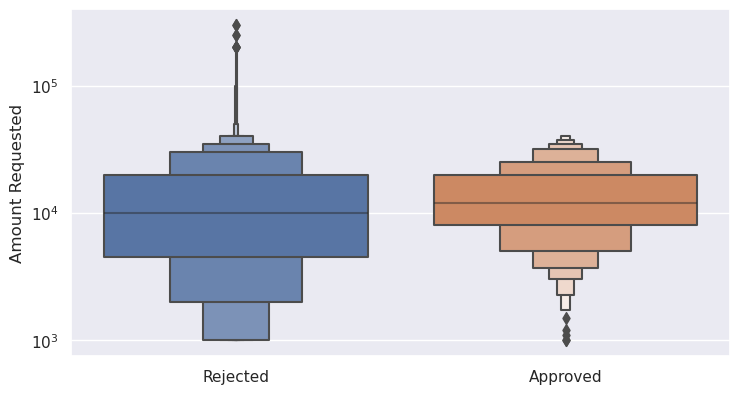

In [27]:
fig_requested_box, ax_requested_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_mini_train.filter(X_mini_eda["Amount Requested"].is_not_null()).to_numpy(),
    y=X_mini_eda["Amount Requested"].drop_nulls().to_numpy(),
    ax=ax_requested_box
)
ax_requested_box.set_yscale("log")
ax_requested_box.set_ylabel("Amount Requested")
ax_requested_box.set_xticklabels(('Rejected','Approved'))
plt.show()

In [28]:
X_mini_eda.null_count()

Amount Requested,Debt-To-Income Ratio,title_contains_numbers,title_length,title_starts_with_lowercase,title,Zip Code,State,Employment Length
u32,u32,u32,u32,u32,u32,u32,u32,u32
2,323,8,8,8,1401,7446,3476,328


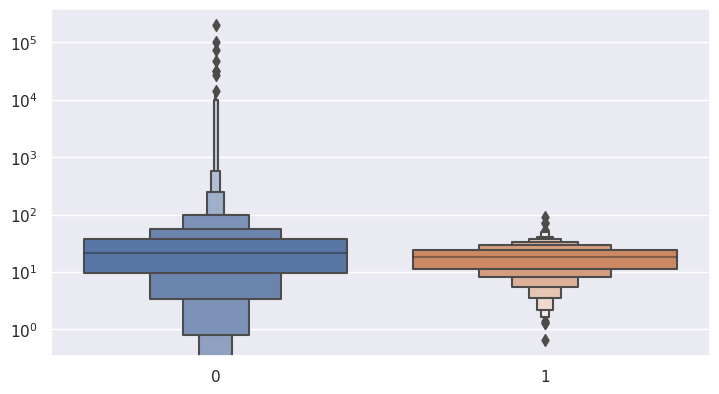

In [29]:
fig_dti_box, ax_dti_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_mini_train.filter(X_mini_eda["Debt-To-Income Ratio"].is_not_null()).to_numpy(),
    y=X_mini_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .to_numpy(),

    ax=ax_dti_box
)

ax_dti_box.set_yscale("log")
plt.show()

In [30]:
dti_non_zero = (
    X_mini_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_mini_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
    .to_numpy()
)
dti_non_zero_y = y_mini_train.filter(
    X_mini_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_mini_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
dti_zero_x = (
    X_mini_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_mini_eda["Debt-To-Income Ratio"].drop_nulls() == 0)
)
dti_zero_y = y_mini_train.filter(
    X_mini_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_mini_eda["Debt-To-Income Ratio"].drop_nulls() == 0)

bins = dmf.create_bins((dti_non_zero), 50, log=True)

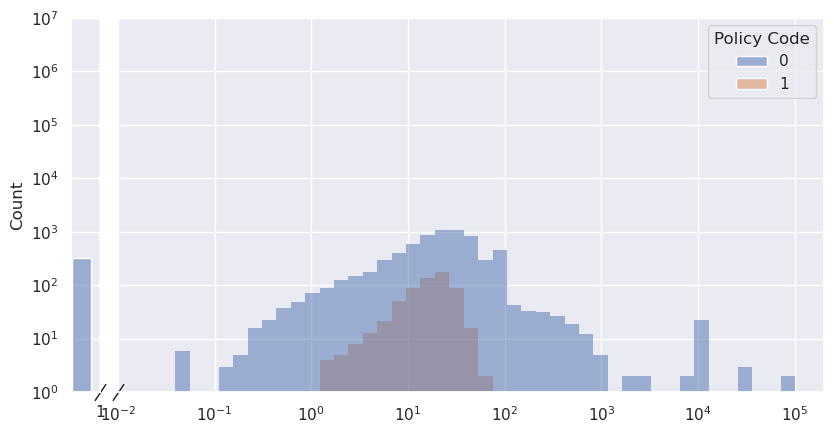

In [31]:
fig_dti_hist, ax_dti_hist = plt.subplots(
    1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 25]}, figsize=BASE_FIG_SIZE
)

sns.histplot(x=dti_non_zero, bins=bins, hue=dti_non_zero_y, ax=ax_dti_hist[1])
ax_dti_hist[1].set_xscale("log")
ax_dti_hist[1].set_yscale("log")
ax_dti_hist[1].set_ylim(1, 1e7)
ax_dti_hist[1].set_xlim(bins[0], bins[-1])
sns.histplot(
    x=dti_zero_x.to_numpy(),
    bins=1,
    hue=dti_zero_y.to_numpy(),
    ax=ax_dti_hist[0],
    legend=False,
)

pf.plot_x_axis_break(ax_dti_hist[0],ax_dti_hist[1])

ax_dti_hist[0].set_xticks([1])

plt.tight_layout(w_pad=-0.5)
plt.show()

In [32]:
state_counts=pl.DataFrame({'State':X_mini_eda['State'],'accepted':y_mini_train}).group_by('State').agg(
    pl.count().alias('Application Count'),
    (pl.sum('accepted')/pl.count()*100).alias('Accepted Percentage')
)

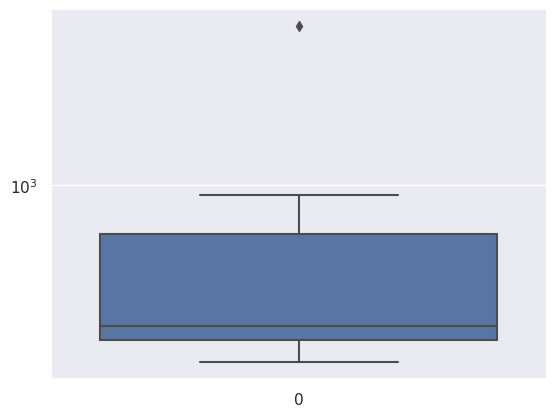

In [33]:
sns.boxplot(state_counts['Application Count'])
plt.yscale('log')

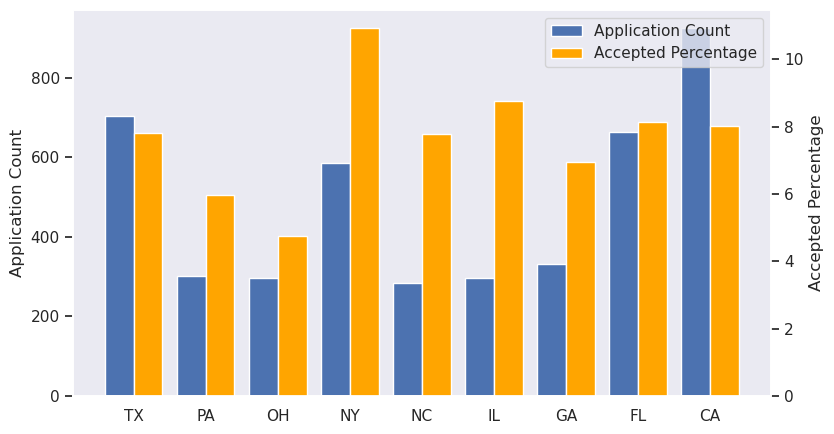

In [34]:
fig_state_counts, ax_state_counts = pf.plot_grouped_bars(
    state_counts, return_fig=True, top_vals=10,figsize_args={'figsize':BASE_FIG_SIZE}
)

In [35]:
work_time_counts=pl.DataFrame({'Employment Length':X_mini_eda['Employment Length'],'accepted':y_mini_train}).group_by('Employment Length').agg(
    pl.count().alias('Application Count'),
    (pl.sum('accepted')/pl.count()*100).alias('Accepted Percentage')
)
work_time_counts=work_time_counts.fill_null('None')

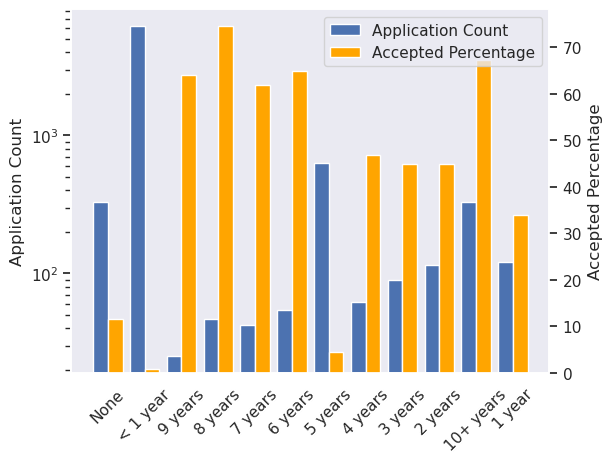

In [36]:
fig_emp_length, ax_empl_length = pf.plot_grouped_bars(
    work_time_counts, x_label_args={"rotation": 45}, return_fig=True
)

ax_empl_length[0].set_yscale('log')

In [37]:
X_mini_eda.head()

Amount Requested,Debt-To-Income Ratio,title_contains_numbers,title_length,title_starts_with_lowercase,title,Zip Code,State,Employment Length
f64,f64,bool,u32,bool,str,str,str,str
21000.0,27.290001,false,11,true,"""car""",null,"""CA""","""5 years"""
20000.0,2628.580078,false,18,true,"""debt_consolida…",null,"""TX""","""5 years"""
19125.0,52.21,false,18,true,"""debt_consolida…",null,null,"""< 1 year"""
9000.0,18.24,false,18,true,"""debt_consolida…",null,null,"""< 1 year"""
35000.0,45.75,false,11,true,"""car""",null,"""CA""","""< 1 year"""


In [38]:
numeric_columns = X_mini_eda.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).columns
categorical_columns = [col for col in X_mini_eda.columns if col not in numeric_columns]
numeric_columns_idx=[X_mini_eda.columns.index(val) for val in numeric_columns]
categorical_column_idx=[X_mini_eda.columns.index(val) for val in categorical_columns]

In [39]:
# X_mini_eda.write_parquet('X_mini_eda.parquet')
# X_mini_eda = pl.read_parquet('X_mini_eda.parquet')

In [40]:
state_encoder = tr.PolarsOneHotEncoder()
zip_encoder = tr.PolarsOneHotEncoder()
title_encoder = tr.PolarsOneHotEncoder()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder=tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(state_encoder, "State"),
        tr.PolarsColumnTransformer.Step(zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step(title_encoder, "title"),
        tr.PolarsColumnTransformer.Step(employment_encoder, "Employment Length"),
    ]
)

In [41]:

loan_classifier=lgb.LGBMClassifier(class_weight='balanced',force_col_wise=True)

In [42]:
X_mini_val=text_preprocessing_wo_training(X_mini_val)


In [43]:
full_pipeline = Pipeline(
    [
        ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder)])),
        ("model", loan_classifier),
    ]
)

In [50]:
from ray import train, tune
from sklearn.metrics import f1_score


search_space = {
    'model__num_leaves': tune.randint(10, 100),
    'model__learning_rate': tune.loguniform(0.001, 0.1),
    'model__feature_fraction': tune.uniform(0.5, 1.0),
    'model__bagging_fraction': tune.uniform(0.5, 1.0),
    'model__n_estimators': tune.randint(10,250)
}

def objective(x,params):
    full_pipeline.set_params(**params)
    full_pipeline.fit(X_mini_eda,y_mini_train)
    preds=full_pipeline.predict(X_mini_val)
    f1=f1_score(y_mini_val,preds)
    print(f'trial {x}')
    return f1

class Trainable(tune.Trainable):
    def setup(self, config: dict):
        # config (dict): A dict of hyperparameters
        self.x = 0
        self.params=config

    def step(self):  # This is called iteratively.
        score = objective(self.x, self.params)
        self.x += 1
        return {"score": score}


tuner = tune.Tuner(
    Trainable,
    run_config=train.RunConfig(
        # Train for 20 steps
        stop={"training_iteration": 5},
        checkpoint_config=train.CheckpointConfig(
            # We haven't implemented checkpointing yet. See below!
            checkpoint_at_end=False
        ),
    ),
    param_space=search_space,
)
results = tuner.fit()

(Trainable pid=11153) [LightGBM] [Warning] feature_fraction is set=0.5696684849141163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696684849141163
(Trainable pid=11153) [LightGBM] [Warning] bagging_fraction is set=0.793605381766705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793605381766705
(Trainable pid=11153) [LightGBM] [Warning] feature_fraction is set=0.5696684849141163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696684849141163
(Trainable pid=11153) [LightGBM] [Warning] bagging_fraction is set=0.793605381766705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793605381766705
(Trainable pid=11153) [LightGBM] [Info] Number of positive: 613, number of negative: 7499
(Trainable pid=11153) [LightGBM] [Info] Total Bins 547
(Trainable pid=11153) [LightGBM] [Info] Number of data points in the train set: 8112, number of used features: 35
(Trainable pid=11153) [LightGBM] [Info] [binary:BoostFr

2023-09-28 14:37:26,909	INFO tune.py:1143 -- Total run time: 1.91 seconds (1.88 seconds for the tuning loop).


(Trainable pid=11153) [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(Trainable pid=11153) [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(Trainable pid=11153) [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(Trainable pid=11153) [LightGBM] [Warning] feature_fraction is set=0.5696684849141163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696684849141163
(Trainable pid=11153) [LightGBM] [Warning] bagging_fraction is set=0.793605381766705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793605381766705
(Trainable pid=11153) trial 4


In [53]:
results.get_best_result().config

{'model__num_leaves': 70,
 'model__learning_rate': 0.015690923278762498,
 'model__feature_fraction': 0.5696684849141163,
 'model__bagging_fraction': 0.793605381766705,
 'model__n_estimators': 66}

In [ ]:
preds=full_pipeline.predict(X_mini_val)

In [ ]:
print(classification_report(y_mini_val,preds))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    500000
           1       0.50      0.92      0.65     40883

    accuracy                           0.93    540883
   macro avg       0.75      0.92      0.80    540883
weighted avg       0.96      0.93      0.93    540883



In [ ]:
import shap

explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(100, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(100, seed=1)).to_numpy()
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
names=full_pipeline['preprocess'].transform(X_mini_val.sample(100,seed=1)).columns

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


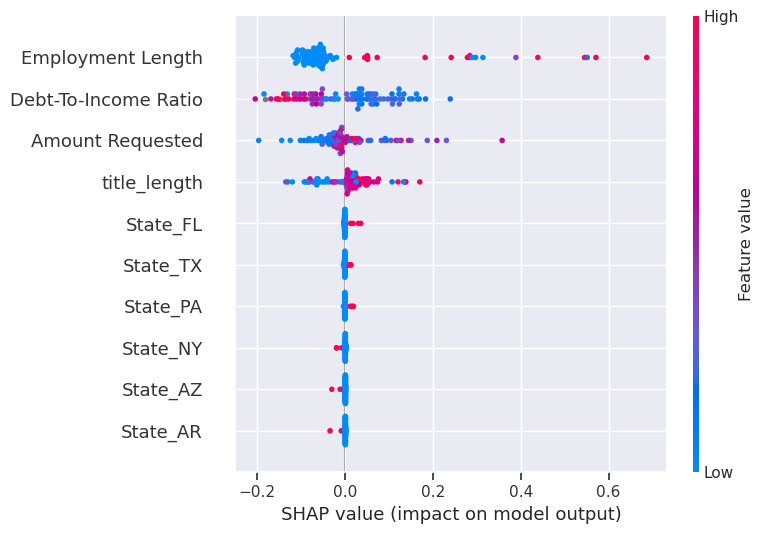

In [ ]:
shap.summary_plot(
    shap_values,
    full_pipeline['preprocess'].transform(X_mini_val.sample(100,seed=1))
    .to_numpy(),
    feature_names=names,
    max_display=10
)